강사노트 [링크](https://www.kaggle.com/code/linakeepgoing/4-optbinning)

In [49]:
# Library
import pandas as pd
import numpy as np
import warnings
import hashlib
import random


warnings.filterwarnings('ignore')

In [50]:
# Data Load
data_path = "../data/amex-default-prediction/train_df_sample.pkl"
df = pd.read_pickle(data_path)
df.reset_index(inplace=True)

## 전처리(이전 작업과 동일)

In [51]:
def drop_null_cols(df, threshold=0.8):
    """
    데이터프레임에서 결측치 비율이 threshold 이상인 변수를 제거하는 함수
    """
    null_percent = df.isnull().mean()
    drop_cols = list(null_percent[null_percent >= threshold].index)
    df = df.drop(drop_cols, axis=1)
    # print(f"Dropped {len(drop_cols)} columns: {', '.join(drop_cols)}")
    return df

def encode_customer_id(id_str):
    encoded_id = hashlib.sha256(id_str.encode('utf-8')).hexdigest()[:16]
    return encoded_id

In [52]:
df['customer_ID'] = df['customer_ID'].apply(encode_customer_id)
df = drop_null_cols(df)

In [53]:
# 범주형 변수 지정
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_68"]
cat_features = [f"{cf}_last" for cf in cat_features]

In [54]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if 'target' not in col and col not in cat_features]
num_cols_sample = random.sample([col for col in num_cols if 'target' not in col], 100)

feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

df = df[all_list]

In [55]:
feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

df = df[all_list]

In [56]:
import gc
gc.collect()

26514

In [57]:
for categorical_feature in cat_features:
    if df[categorical_feature].dtype == 'float16':
        df[categorical_feature] = df[categorical_feature].astype(str)
    if df[categorical_feature].dtype == 'category':
        df[categorical_feature] = df[categorical_feature].astype(str)    
    elif df[categorical_feature].dtype == 'object':
        df[categorical_feature] = df[categorical_feature].astype(str)

In [58]:
from sklearn.preprocessing import LabelEncoder

le_encoder = LabelEncoder()

for categorical_feature in cat_features:
    df[categorical_feature].fillna(value='NaN', inplace=True)
    df[categorical_feature] = le_encoder.fit_transform(df[categorical_feature])

In [59]:
from sklearn.impute import SimpleImputer

def impute_nan(df, num_cols, strategy='mean'):
    """
    NaN 값을 strategy에 따라 num_cols에 대해 impute하는 함수
    
    :param df: DataFrame
    :param num_cols: list, imputation 대상 numeric column 리스트
    :param strategy: str, imputation 전략 (default: 'mean')
    :return: DataFrame, imputed DataFrame
    """
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df

df = impute_nan(df,num_cols_sample, strategy="mean")

In [60]:
df.sample(5)

,R_2_max,D_63_count,B_33_last,D_78_mean,R_10_min,D_130_min,B_36_max,D_130_mean,S_26_std,S_17_last,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_68_last,target
73103,0.009506,13.0,1.001953,0.005688,0.000502,0.001781,0.009445,0.006714,0.002596,0.005123,...,0,1,0,4,0,1,1,3,6,0
76655,0.009499,12.0,1.004883,0.005177,0.000570,0.001502,0.009872,0.005600,0.002553,0.007801,...,0,0,0,3,0,1,2,1,6,0
23012,0.009483,13.0,1.001953,0.004978,0.000183,0.000558,0.008842,0.005695,0.002439,0.007168,...,0,1,0,4,0,0,1,1,5,0
629,1.008789,7.0,0.009438,0.004234,0.000031,0.000511,0.009445,0.004662,0.002801,0.004520,...,4,1,0,3,0,0,1,3,3,0
38345,0.009567,13.0,0.001039,0.004890,0.002325,0.000082,0.008934,0.005390,0.380256,0.002443,...,2,1,0,0,0,1,2,2,6,0


## `OptBinning`

Binning Process는 데이터셋의 변수들을 이진, 연속형 또는 다중 클래스 타겟 데이터 유형을 기반으로 최적의 구간화(bin)을 계산하기 위한 프로세스.   

매개변수:    
|var|desc|
|---|---|
|`variable_names (array-like)`| 변수 이름의 리스트.|   
|`max_n_prebins (int, default=20)`| Pre-binning(사전 구간화) 후의 최대 구간 수.|  
|`min_prebin_size (float, default=0.05)`| 각 Pre-bin에 대한 최소 레코드 수의 비율.|  
|`min_n_bins (int 또는 None, optional, default=None)`| 최소 구간 수. None인 경우, min_n_bins은 [0, max_n_prebins] 범위의 값.|  
|`max_n_bins (int 또는 None, optional, default=None)`| 최대 구간 수. None인 경우, max_n_bins은 [0, max_n_prebins] 범위의 값.|  
|`min_bin_size (float 또는 None, optional, default=None)`| 각 구간의 최소 레코드 수의 비율. None인 경우, min_bin_size = min_prebin_size.|
|`max_bin_size (float 또는 None, optional, default=None)`| 각 구간의 최대 레코드 수의 비율. None인 경우, max_bin_size = 1.0.|
|`max_pvalue (float 또는 None, optional, default=None)`| 구간 간의 최대 p-value.|
|`max_pvalue_policy (str, optional, default="consecutive")`| p-value 조건을 만족하지 않는 구간을 결정하는 방법. "consecutive"는 연속된 구간을 비교하고, "all"은 모든 구간을 비교.|
|`selection_criteria (dict 또는 None, optional, default=None)`| 변수 선택 기준. |
|`fixed_variables (array-like 또는 None, optional, default=None)`| 고정할 변수의 리스트. 선택 기준을 만족하지 않을 경우에도 이러한 변수를 유지.|
|`special_codes (array-like 또는 None, optional, default=None)`| 특별한 코드의 리스트. 이러한 코드를 사용하여 따로 처리해야 하는 데이터 값을 지정할 수 있음.|
|`split_digits (int 또는 None, optional, default=None)`| 분할 지점의 유효 숫자 자릿수. split_digits가 0으로 설정되면 분할 지점은 정수로 처리. None인 경우, 분할 지점의 모든 유효 숫자 자릿수가 고려.|
|`categorical_variables (array-like 또는 None, optional, default=None)`| 범주형 변수로 간주할 수치 변수의 리스트. 이는 명목 변수. 타겟 유형이 다중 클래스인 경우에는 해당되지 않음.|
|`binning_fit_params (dict 또는 None, optional, default=None)`| 특정 변수에 대한 최적|

In [61]:
from optbinning import BinningProcess

구간화(binning) 프로세스 후 각 변수의 선택 여부를 결정하는 데 사용되는 기준 정의하기 
- `min` : IV 값이 0.025 이상인 변수만 고려.
- `max` : IV 값이 0.7 이하인 변수만 고려. 너무 높은 IV 값은 변수가 과도하게 타깃에 의존하고 있음을 나타낼 수 있음(과적합 방지)
- `strategy` : highest 전략을 사용하여 IV가 가장 높은 변수들을 우선적으로 선택
- `top` : 상위 20개의 변수만 선택. 모델의 복잡성을 관리하고 가장 유의미한 변수들만을 포함하기 위해

In [62]:
selection_criteria = {
    "iv": {"min": 0.025, "max": 0.7, "strategy": "highest", "top": 20},
    "quality_score": {"min": 0.01}
}

In [63]:
binning_process = BinningProcess(feature_list,
                                 categorical_variables=cat_features,
                                 selection_criteria=selection_criteria)

X = df[feature_list]
y = df['target']

binning_process.fit(X, y)

BinningProcess(categorical_variables=['B_30_last', 'B_38_last', 'D_114_last',
                                      'D_116_last', 'D_117_last', 'D_120_last',
                                      'D_126_last', 'D_63_last', 'D_64_last',
                                      'D_68_last'],
               selection_criteria={'iv': {'max': 0.7, 'min': 0.025,
                                          'strategy': 'highest', 'top': 20},
                                   'quality_score': {'min': 0.01}},
               variable_names=['R_2_max', 'D_63_count', 'B_33_last',
                               'D_78_mean', 'R_10_min', 'D_130_min', 'B_36_max',
                               'D_130_mean', 'S_26_std', 'S_17_last',
                               'D_124_last', 'D_144_std', 'B_13_mean',
                               'D_65_std', 'D_45_mean', 'D_96_mean', 'R_28_min',
                               'R_8_last', 'B_27_max', 'S_7_mean', 'D_91_max',
                               'B_12_mean', 'D_104_last', 'R_7_last',
                               'S_5_last', 'B_26_min', 'D_48_min', 'R_1_last',
                               'D_58_std', 'B_7_last', ...])

`information` 메서드는 구간화 작업에 대한 상세 정보를 출력.   
`print_level` 로 출력 정보의 상세 수준 지정

In [64]:
binning_process.information(print_level=2)

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                         no   * d
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                 1000

`summary()` 메서드는 `binning_process` 객체가 수행한 구간화 과정의 요약 정보 제공.  

In [65]:
binning_process.summary() 

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,R_2_max,numerical,OPTIMAL,False,7,0.935015,0.102961,0.396673,0.183639
1,D_63_count,numerical,OPTIMAL,False,2,0.092693,0.011423,0.117214,0.134381
2,B_33_last,numerical,OPTIMAL,False,6,1.675441,0.192412,0.594654,0.000079
3,D_78_mean,numerical,OPTIMAL,False,5,1.048565,0.115511,0.450206,0.076095
4,R_10_min,numerical,OPTIMAL,False,10,0.045005,0.00557,0.100841,0.000425
...,...,...,...,...,...,...,...,...,...
105,D_120_last,categorical,OPTIMAL,False,2,0.263812,0.032023,0.21299,0.358816
106,D_126_last,categorical,OPTIMAL,False,2,0.018833,0.002349,0.058528,0.036601
107,D_63_last,categorical,OPTIMAL,False,3,0.044258,0.005484,0.083182,0.08972
108,D_64_last,categorical,OPTIMAL,False,3,0.209134,0.025906,0.232605,0.563629


!! 선택된 변수만 따로 보기. 

In [66]:
summary = binning_process.summary()

selected_summary = summary[summary["selected"] == True]
selected_summary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
12,B_13_mean,numerical,OPTIMAL,True,14,0.441157,0.052017,0.344871,0.927662
13,D_65_std,numerical,OPTIMAL,True,11,0.636856,0.074327,0.364229,0.052763
17,R_8_last,numerical,OPTIMAL,True,5,0.344899,0.0358,0.144052,0.028803
21,B_12_mean,numerical,OPTIMAL,True,10,0.304687,0.037166,0.291299,0.714441
31,D_54_mean,numerical,OPTIMAL,True,5,0.321502,0.034556,0.160243,0.753453
34,D_92_last,numerical,OPTIMAL,True,7,0.293369,0.02813,0.106444,0.015569
36,R_20_std,numerical,OPTIMAL,True,8,0.362172,0.03889,0.18698,0.329637
42,D_39_mean,numerical,OPTIMAL,True,13,0.596497,0.067924,0.373433,0.535888
50,B_25_max,numerical,OPTIMAL,True,7,0.479676,0.057438,0.328176,0.552055
54,B_16_min,numerical,OPTIMAL,True,12,0.641799,0.076895,0.437091,0.412744


특정 변수의 구간화 정보 추출하기 -> 반환된 객체 `optb` 는 해당 변수의 구간화 설정과 결과 담고 있음.   
`build()` 메서드는 구간화된 데이터에 대한 상세한 테이블을 구축. 

In [72]:
optb = binning_process.get_binned_variable("D_92_last")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",14921,0.14921,10770,4151,0.278199,-0.089074,0.001209,0.000151
1,"[0.00, 0.00)",23752,0.23752,17114,6638,0.279471,-0.095403,0.002211,0.000276
2,"[0.00, 0.01)",13052,0.13052,9374,3678,0.281796,-0.106918,0.001530,0.000191
3,"[0.01, 0.01)",5590,0.05590,3995,1595,0.285331,-0.124319,0.000889,0.000111
4,"[0.01, 0.01)",6735,0.06735,4761,1974,0.293096,-0.162093,0.001837,0.000229
5,"[0.01, 0.01)",28005,0.28005,20133,7872,0.281093,-0.103441,0.003070,0.000384
6,"[0.01, inf)",7945,0.07945,7786,159,0.020013,2.848689,0.282624,0.026788
7,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,100000,1.00000,73933,26067,0.260670,,0.293369,0.028130


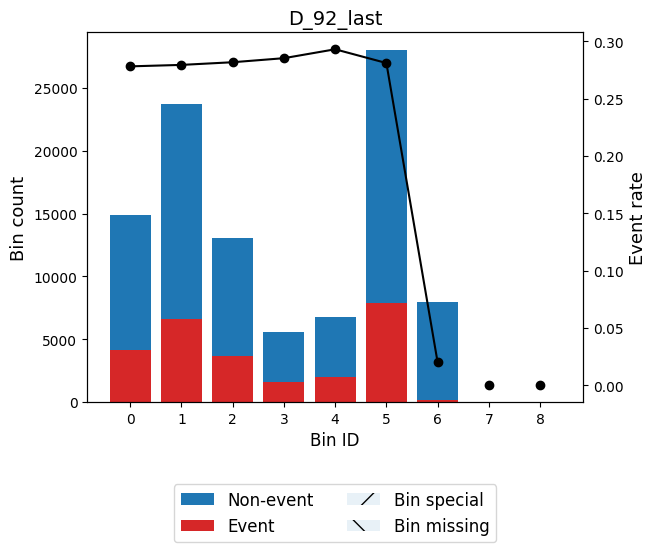

In [ ]:
# 구간화 그래프 그리기 : 5구간이 불량률 가장 높음. 
optb.binning_table.plot(metric="event_rate")

일반적으로 구간화는 이벤트 발생 확률이 단조 증가하면 좋다고 판단함. 

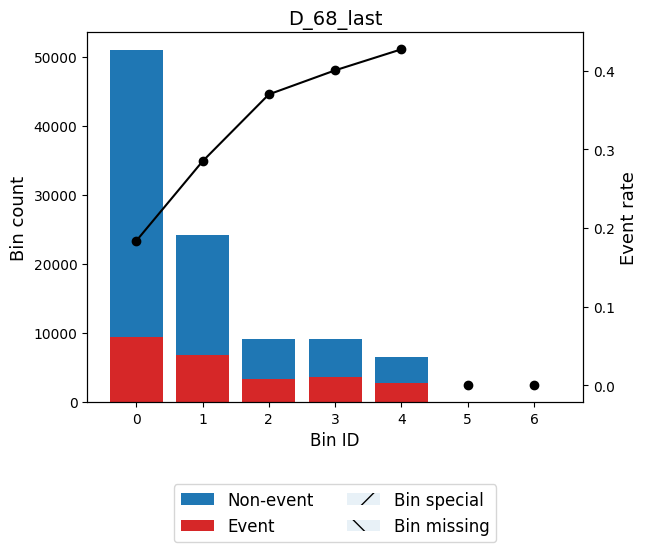

In [70]:
optb = binning_process.get_binned_variable("D_68_last")
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate")

`optb.binning_table.plot(metric="event_rate")`에서 `metric`은 그래프를 그릴 때 사용할 메트릭(metric)을 지정하는 매개변수.  
이 메트릭은 각 구간(bin)의 값을 기준으로 그래프를 그릴 때 사용. 예를 들어, "event_rate"를 지정하면 각 구간의 이벤트 발생 비율을 기준으로 그래프를 그림.  
optb.binning_table.plot()은 optbinning 패키지에서 사용되는 BinningTable 객체의 메서드.   
`BinningTable` 객체는 변수의 구간(bin) 정보를 저장하고 분석 결과를 시각화할 수 있는 기능을 제공.   
이를 통해 각 구간의 특성을 시각적으로 확인하고 모델 개발에 유용한 통찰력을 얻을 수 있음.   
plot() 메서드를 사용하여 구간별 메트릭에 대한 그래프를 생성하고 시각화할 수 있음.   
metric 매개변수를 적절히 설정하여 원하는 메트릭에 대한 그래프를 생성할 수 있음.

In [ ]:
# 최종 선택된 변수 
binning_process.get_support(names=True)

array(['B_13_mean', 'D_65_std', 'R_8_last', 'B_12_mean', 'D_54_mean',
       'D_92_last', 'R_20_std', 'D_39_mean', 'B_25_max', 'B_16_min',
       'R_3_min', 'R_27_max', 'R_24_std', 'R_3_last', 'D_77_std',
       'D_56_min', 'D_75_std', 'S_8_last', 'B_10_std'], dtype='<U13')

`transform` 메서드에서 `WoE` 메트릭을 사용하면 각 변수를 구간화된 값으로 변환해줌.  
즉, 데이터 X의 모든 특성을 WoE값으로 매핑한 새로운 데이터 프레임 `X_transform` 생성

In [74]:
X_transform = binning_process.transform(X, metric="woe")

In [75]:
X_transform

,B_13_mean,D_65_std,R_8_last,B_12_mean,D_54_mean,D_92_last,R_20_std,D_39_mean,B_25_max,B_16_min,R_3_min,R_27_max,R_24_std,R_3_last,D_77_std,D_56_min,D_75_std,S_8_last,B_10_std
0,-0.355297,0.450282,0.169627,-0.211871,-0.000805,-0.124319,-0.084724,-0.322156,-0.450971,1.012388,-1.449929,-0.174490,-0.126455,-0.347783,-0.692265,-0.472932,1.002804,-0.807160,0.383380
1,0.900079,-1.600887,0.116091,1.086975,0.158161,-0.095403,0.169509,-0.322156,0.356950,1.012388,0.110431,0.297873,0.152084,0.497091,1.163460,-0.472932,-0.209382,1.331986,0.383380
2,0.074783,-1.010835,0.116091,-0.448184,0.158161,-0.103441,-0.106410,1.689064,-0.450971,1.185179,-1.449929,-0.174490,-0.126455,0.008895,-0.310301,-0.472932,-0.094241,-0.402995,0.383380
3,0.669510,0.523060,0.154445,0.965905,0.130688,2.848689,0.204294,-0.185912,-0.488858,1.012388,0.533254,0.211263,0.204618,0.497091,-0.310301,1.696139,1.002804,1.805010,0.978818
4,-0.209895,0.540528,0.159265,0.381705,0.130688,-0.103441,0.172777,-0.056159,0.356950,0.447080,0.333482,0.297873,0.190744,0.008895,1.163460,0.237473,1.002804,1.571242,0.978818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.669510,-1.600887,0.154445,0.965905,0.194880,-0.162093,0.172777,-0.255602,1.060599,-1.137878,0.533254,0.211263,0.204618,0.008895,-0.842583,0.237473,-0.388125,0.606627,-0.131641
99996,0.669510,0.450282,0.159265,1.086975,0.130688,2.848689,0.345094,-0.056159,1.504210,-0.121871,0.514048,0.247445,0.222096,0.497091,0.323799,-0.472932,0.841721,1.571242,0.383380
99997,-0.220137,0.485600,0.154445,-0.497735,-0.000805,-0.103441,0.204294,0.081908,1.504210,-0.436001,0.333482,0.297873,0.204618,0.497091,1.163460,0.237473,-0.645656,-0.166673,0.383380
99998,-0.646098,0.523060,0.116091,0.292978,0.130688,-0.089074,0.192938,0.191713,-0.450971,0.447080,0.514048,0.297873,0.204618,0.497091,1.487317,0.970457,0.841721,-0.106743,-0.811091


In [76]:
from sklearn.linear_model import LogisticRegression
from optbinning import Scorecard
from optbinning.scorecard import Counterfactual

binning_process = BinningProcess(feature_list,
                                 categorical_variables=cat_features,
                                 selection_criteria=selection_criteria)

estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

scorecard.fit(X, y)

Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                'B_38_last',
                                                                'D_114_last',
                                                                'D_116_last',
                                                                'D_117_last',
                                                                'D_120_last',
                                                                'D_126_last',
                                                                'D_63_last',
                                                                'D_64_last',
                                                                'D_68_last'],
                                         selection_criteria={'iv': {'max': 0.7,
                                                                    'min': 0.025,
                                                                    'strategy': 'highest',
                                                                    'top': 20},
                                                             'quality_score': {'min': 0.01}},
                                         variable_names=['R_2_max',
                                                         'D_63_count',
                                                         'B_33_last',...
                                                         'S_26_std',
                                                         'S_17_last',
                                                         'D_124_last',
                                                         'D_144_std',
                                                         'B_13_mean',
                                                         'D_65_std',
                                                         'D_45_mean',
                                                         'D_96_mean',
                                                         'R_28_min', 'R_8_last',
                                                         'B_27_max', 'S_7_mean',
                                                         'D_91_max',
                                                         'B_12_mean',
                                                         'D_104_last',
                                                         'R_7_last', 'S_5_last',
                                                         'B_26_min', 'D_48_min',
                                                         'R_1_last', 'D_58_std',
                                                         'B_7_last', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

이미지 스코어 카드로 모델의 세부사항 확인 가능 

In [77]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,B_13_mean,"(-inf, 0.01)",26.325532
1,B_13_mean,"[0.01, 0.01)",28.381280
2,B_13_mean,"[0.01, 0.01)",32.789873
3,B_13_mean,"[0.01, 0.01)",34.267535
4,B_13_mean,"[0.01, 0.02)",34.560472
...,...,...,...
8,B_10_std,"[0.03, 0.04)",34.121645
9,B_10_std,"[0.04, 0.24)",36.652209
10,B_10_std,"[0.24, inf)",45.969096
11,B_10_std,Special,32.045399


`JS Distance`는 각 구간의 신용 점수 분포 간의 거리 측정하는 지표.  
스코어 카드에서 JS는 구간별로 신용 점수가 얼마나 다른지를 보여줌.  
구간별 신용 점수 분포가 서로 다를수록 JS 값은 높아지며, 구간 간 부리도가 높음을 나타냄.  
이는 스코어 카드가 독립 변수의 변화에 따라 점수를 적절하게 조정하여 신용 등급을 산출할 수 있도록 도와줌.  

In [ ]:
scorecard.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,B_8_max,0,"(-inf, 0.01)",25179,0.25179,22048,3131,0.124350,0.909380,0.161963,0.019575,-0.739064,53.558191
1,B_8_max,1,"[0.01, 0.27)",23033,0.23033,20152,2881,0.125081,0.902677,0.146277,0.017688,-0.739064,53.392948
2,B_8_max,2,"[0.27, 1.01)",5957,0.05957,4063,1894,0.317945,-0.279259,0.004944,0.000616,-0.739064,24.257304
3,B_8_max,3,"[1.01, 1.01)",6471,0.06471,4174,2297,0.354968,-0.445218,0.014097,0.001748,-0.739064,20.166265
4,B_8_max,4,"[1.01, 1.01)",18676,0.18676,11457,7219,0.386539,-0.580605,0.070820,0.008730,-0.739064,16.828882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,R_14_max,6,"[0.01, 0.01)",5949,0.05949,4699,1250,0.210119,0.281717,0.004396,0.000548,-0.222355,33.230586
7,R_14_max,7,"[0.01, 0.33)",18800,0.18800,14622,4178,0.222234,0.210205,0.007882,0.000983,-0.222355,32.700224
8,R_14_max,8,"[0.33, inf)",5852,0.05852,1422,4430,0.757006,-2.178824,0.328377,0.034470,-0.222355,14.982114
9,R_14_max,9,Special,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000,-0.222355,31.141247


In [ ]:
sc = scorecard.table(style="summary")
sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum()

Points  min    300.0
        max    850.0
dtype: float64

In [ ]:
y_pred = scorecard.predict_proba(X)[:, 1]

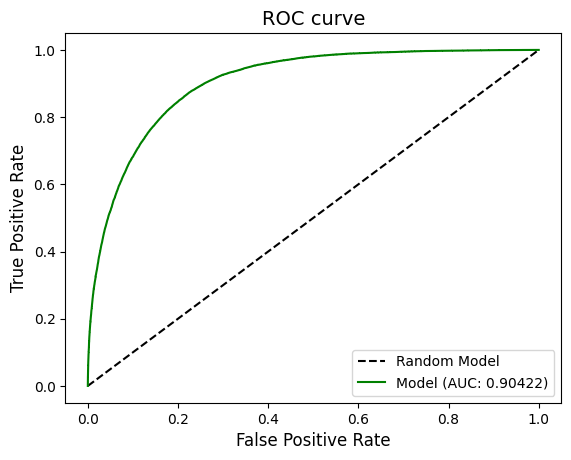

In [ ]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
plot_auc_roc(y, y_pred)

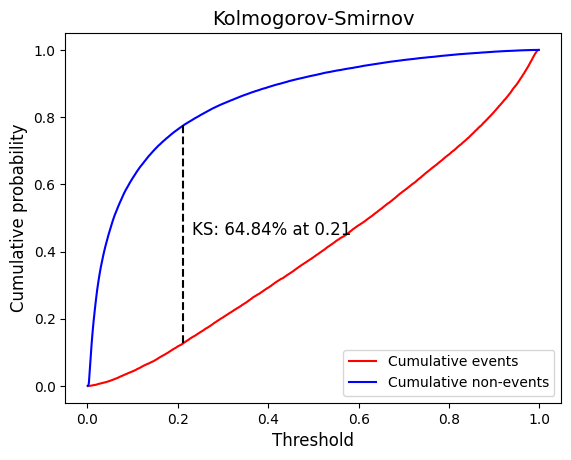

In [ ]:
plot_ks(y, y_pred)

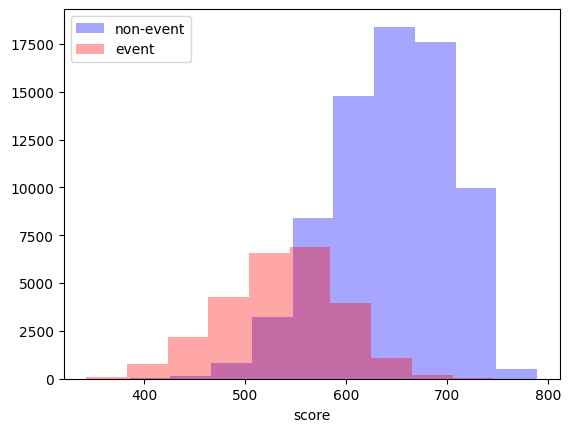

In [ ]:
score = scorecard.score(X)


import matplotlib.pyplot as plt
mask = y == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

## `OptBinning` 사용한 모델 모니터링

`Model Drift` : 모델의 예측력이 예상 밖으로 변하는 현상  
- 모델 드리프트를 식별하고 관리하는 것은 모델의 신뢰성을 유지하고 장기적인 성과를 보장하는 데 필수 .
-----

`OptBinnin` 라이브러리는 모니터링 작업을 용이하게 하는 다양한 기능 제공.   
그중에서도 모델이 생성된 시점과 현재 또는 특정 시점의 데이터 분포가 얼마나 변화했는지를 측정하는 지표인 `PSI`를 계산함으로써, 모델 입력 변수의 분포가 시간에 따라 어떻게 변하는지 정량적으로 평가할 수 있음.  

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                'B_38_last',
                                                                'D_114_last',
                                                                'D_116_last',
                                                                'D_117_last',
                                                                'D_120_last',
                                                                'D_126_last',
                                                                'D_63_last',
                                                                'D_64_last',
                                                                'D_68_last'],
                                         selection_criteria={'iv': {'max': 0.7,
                                                                    'min': 0.025,
                                                                    'strategy': 'highest',
                                                                    'top': 20},
                                                             'quality_score': {'min': 0.01}},
                                         variable_names=['D_139_last',
                                                         'D_78_min', 'R_2_mean',...
                                                         'B_6_mean',
                                                         'D_105_mean',
                                                         'D_121_std', 'B_8_max',
                                                         'R_13_max', 'B_4_max',
                                                         'B_40_std', 'D_54_min',
                                                         'B_33_mean',
                                                         'S_19_std',
                                                         'S_26_mean',
                                                         'B_11_min', 'D_45_max',
                                                         'B_27_last',
                                                         'B_28_mean',
                                                         'S_15_max',
                                                         'D_102_max',
                                                         'D_113_mean',
                                                         'S_15_std',
                                                         'B_16_last',
                                                         'P_2_last',
                                                         'D_94_last', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

`ScorecardMonitoring` 객체는 주어진 스코어카드에 대한 모델 성능 모니터링을 위해 여러 파라미터를 받아들임.  
`scorecard`는 모니터링할 스코어카드 모델을 지정.  
`psi_method = "cart"` 는 PSI를 계산할 때 **CART**(classification and regression tree) 알고리즘을 사용한다는 뜻.  
CART 방법은 데이터를 구분하는 결정 트리를 생성하여, 각 구간(bin)의 PSI를 계산.  
`psi_n_bins = 10`은 PSI를 계산할 때 데이터를 10개의 구간으로 나눈다는 뜻.   

In [ ]:
from optbinning.scorecard import ScorecardMonitoring

monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

monitoring.fit(X_test, y_test, X_train, y_train)

2025-08-01 10:39:37,143 | INFO : Monitoring started.
2025-08-01 10:39:37,144 | INFO : Options: check parameters.
2025-08-01 10:39:37,146 | INFO : System stability analysis started.
2025-08-01 10:39:37,974 | INFO : System stability analysis terminated. Time: 0.8267s
2025-08-01 10:39:37,974 | INFO : Variable analysis started.
2025-08-01 10:39:38,154 | INFO : Variable analysis terminated. Time: 0.1801s
2025-08-01 10:39:38,155 | INFO : Monitoring terminated. Time: 1.0119s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                                              'B_38_last',
                                                                                              'D_114_last',
                                                                                              'D_116_last',
                                                                                              'D_117_last',
                                                                                              'D_120_last',
                                                                                              'D_126_last',
                                                                                              'D_63_last',
                                                                                              'D_64_last',
                                                                                              'D_68_last'],
                                                                       selection_criteria={'iv': {'max': 0.7,
                                                                                                  'min': 0.025,
                                                                                                  'strategy': 'highest',
                                                                                                  'top': 20},
                                                                                           'quality_score': {'min': 0.01}},
                                                                       variabl...
                                                                                       'D_105_mean',
                                                                                       'D_121_std',
                                                                                       'B_8_max',
                                                                                       'R_13_max',
                                                                                       'B_4_max',
                                                                                       'B_40_std',
                                                                                       'D_54_min',
                                                                                       'B_33_mean',
                                                                                       'S_19_std',
                                                                                       'S_26_mean',
                                                                                       'B_11_min',
                                                                                       'D_45_max',
                                                                                       'B_27_last',
                                                                                       'B_28_mean',
                                                                                       'S_15_max',
                                                                                       'D_102_max',
                                                                                       'D_113_mean',
                                                                                       'S_15_std',
                                                                                       'B_16_last',
                                                                                       'P_2_last',
                                                                                       'D_94_last', ...]),
                                        estimator=LogisticRegression(),
                                        scaling_method='min_ma

In [ ]:
monitoring.psi_table() # 안정적인 PSI 결과 

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"(-inf, 501.48)",2255,5350,0.075167,0.076429,2.100911e-05
1,"[501.48, 532.21)",1850,4451,0.061667,0.063586,5.880977e-05
2,"[532.21, 559.86)",2647,5988,0.088233,0.085543,8.331683e-05
3,"[559.86, 580.14)",2382,5461,0.079400,0.078014,2.439745e-05
4,"[580.14, 601.26)",2755,6472,0.091833,0.092457,4.223114e-06
5,"[601.26, 619.73)",2601,6141,0.086700,0.087729,1.213071e-05
6,"[619.73, 630.15)",1553,3530,0.051767,0.050429,3.504275e-05
7,"[630.15, 648.91)",2724,6433,0.090800,0.091900,1.324592e-05
8,"[648.91, 673.58)",3573,8286,0.119100,0.118371,4.470584e-06
9,"[673.58, inf)",7660,17888,0.255333,0.255543,1.718625e-07


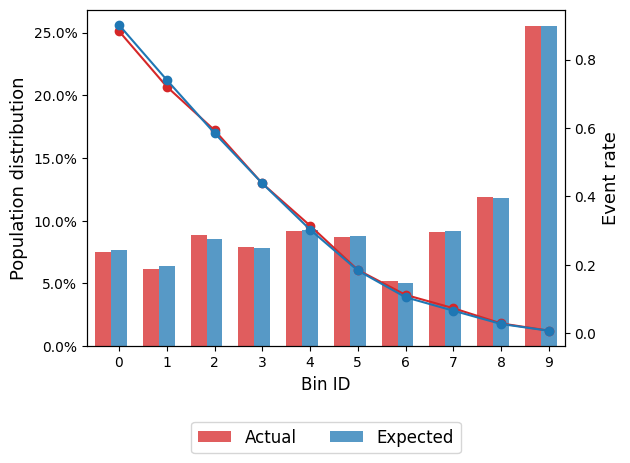

In [ ]:
monitoring.psi_plot()

통계적 검정은 이벤트 비율(카이제곱 검정-이진 타깃) 또는 평균(스튜던트 t-검정-연속 타깃)이 유의하게 다른지 여부를 결정하기 위해 수행.   
귀무가설은 실젯값이 예상값과 동일하다는 것. 

In [ ]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 501.48)",2255,5350,0.883370,0.901495,5.598407,0.017977
1,"[501.48, 532.21)",1850,4451,0.721081,0.740732,2.590788,0.107487
2,"[532.21, 559.86)",2647,5988,0.593502,0.585003,0.547122,0.459496
3,"[559.86, 580.14)",2382,5461,0.437867,0.438198,0.000737,0.978338
4,"[580.14, 601.26)",2755,6472,0.314701,0.303152,1.212258,0.270885
5,"[601.26, 619.73)",2601,6141,0.184929,0.183358,0.030060,0.862353
6,"[619.73, 630.15)",1553,3530,0.112041,0.105099,0.542978,0.461201
7,"[630.15, 648.91)",2724,6433,0.073054,0.065755,1.610577,0.204411
8,"[648.91, 673.58)",3573,8286,0.028547,0.026913,0.250249,0.616900
9,"[673.58, inf)",7660,17888,0.007441,0.007044,0.119116,0.729995


In [ ]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0003 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      1        0.1
    [0.05, 0.10)      0        0.0
    [0.10, 0.50)      5        0.5
    [0.50, 1.00)      4        0.4

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records   30000          -     70000            -
        Event records    7820   0.260667     18247     0.260671
    Non-event records   22180   0.739333     51753     0.739329

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.607289  0.619170   -0.011881
     True negative rate 0.922

In [ ]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,B_10_std,0.000210
1,B_13_min,0.000334
2,B_14_max,0.000246
3,B_25_max,0.000195
4,B_25_std,0.000731
5,B_26_max,0.000319
6,B_28_mean,0.000613
7,B_8_max,0.000254
8,D_53_min,0.000136
9,D_70_last,0.000462
